# Intrasensor divergence for a single sensor

In [1]:
from publicdata import client as c
from functions import *
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import pandas as pd
# %matplotlib widget  #

In [2]:
# Nine sensors related to the inputs, outputs and controls of a compressor subsystem.
# Dictionary made with key=name of sensor and value=Id of sensor
sensors = {
    'PDT-92534': 6908033636680653,
    'PT-92523':8877482139815959,
    'TIC-92504':7012228881452176,
    'TT 92532':8152209984966682,
    'FT-92537':3278479880462408,
    'TT-92539':643849686863640,
    'PT-92539':1890487216163163,
    'ZT 92543':4146236330407219,
    'KA 9101':844472910348820
}
sensor_name = "PT-92523"

# # I'll extract a pandas dataframe for each of the sensors in sensor_names, and these will be stored
# # in the following dictionary, again with the sensor name as the key.
# dfs_dict = {}

# startdate = datetime(2018, 11, 5, tzinfo=timezone.utc)
# enddate = datetime(2018, 11, 15, tzinfo=timezone.utc)

# # print("Sensor name".ljust(15) + "Frame length".ljust(15) + "First period length [s]".ljust(25) + "First timestamp".ljust(15))

# # Extract dataframes from Cognite OID and store them in the dfs_dict dictionary
# for k, v in sensors.items():
#     res = c.time_series.data.retrieve_dataframe(id=v, 
#                                                 start=startdate, 
#                                                 end=enddate, 
#                                                 column_names='id',
#                                                 aggregates=["average"],
#                                                 granularity="30s",)
#     # Need to find a way to grab the unit of the time-series
#     dfs_dict[k] = res
#     sr = (res.index[1] - res.index[0]).total_seconds()
#     # print(f'{k}\'s shape: {res.shape} and sampling frequency: {sr} second(s)')
#     # print(str(k).ljust(15) + str(res.shape).ljust(15) + str(sr).ljust(25) + str(res.index[0]).ljust(15))

days = range(5, 14)
days_df = {}

for day in days:
    startdate = datetime(2018, 11, day, tzinfo=timezone.utc)
    enddate = datetime(2018, 11, day+1, tzinfo=timezone.utc)

    res = c.time_series.data.retrieve_dataframe(id=sensors[sensor_name], 
                                                start=startdate, 
                                                end=enddate, 
                                                column_names='id',
                                                aggregates=["average"],
                                                granularity="30s",)
    # Need to find a way to grab the unit of the time-series
    days_df[startdate.strftime("%x")] = res

# plot_sensor_data('PT-92523', dfs_dict)
# plot_all_nine_sensors(dfs_dict)

print("Data retrieved")

Data retrieved


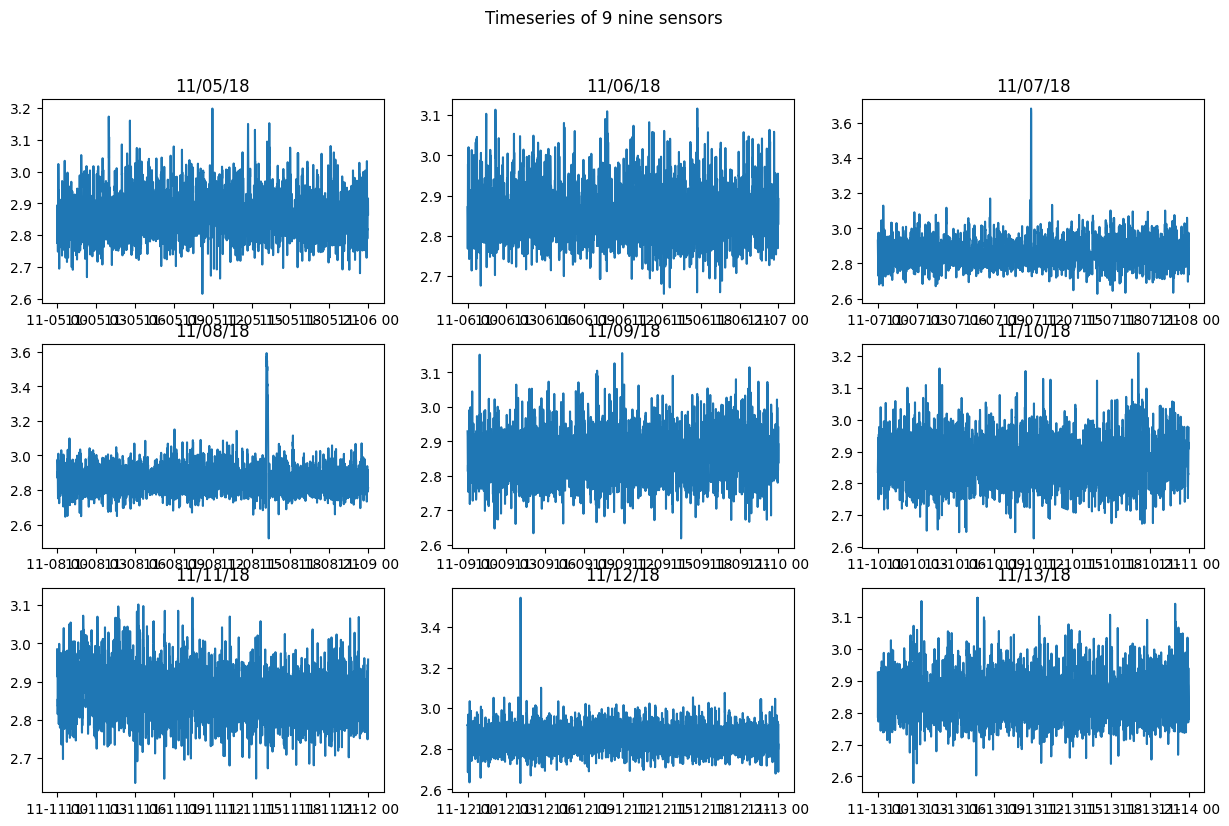

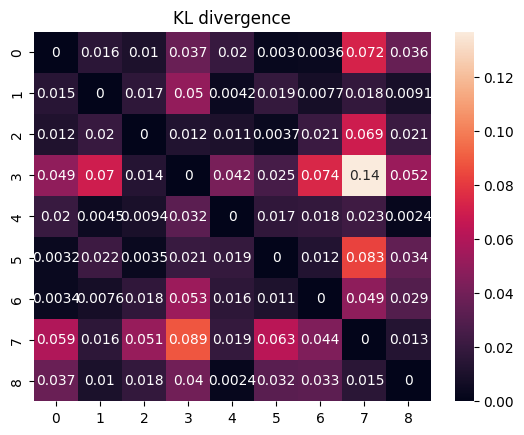

In [3]:
# print(days_df)

plot_all_nine_sensors(days_df)

days_KL = kl_dfs(days_df)
plot_kl(days_KL)


In [4]:
standard_days_df = standardize_dfs(days_df)
resampled_days = reshape_dfs(standard_days_df)
# print(standard_days_df)
correlate_dfs(resampled_days)

11/05/18: Avg: 2.8758708743228487 Std: 0.0710386979609737 Shape: (2873, 1)
11/06/18: Avg: 2.8645691544520515 Std: 0.06790430195461106 Shape: (2853, 1)
11/07/18: Avg: 2.8691572178679947 Std: 0.07717030942190325 Shape: (2868, 1)
11/08/18: Avg: 2.8683169572981413 Std: 0.0863468592654927 Shape: (2870, 1)
11/09/18: Avg: 2.8615630775085132 Std: 0.07199440929501666 Shape: (2806, 1)
11/10/18: Avg: 2.8748370012004374 Std: 0.0750460525760859 Shape: (2877, 1)
11/11/18: Avg: 2.872922429436533 Std: 0.06751524621405902 Shape: (2868, 1)
11/12/18: Avg: 2.853551796613885 Std: 0.06402804040819486 Shape: (2877, 1)
11/13/18: Avg: 2.856586822762833 Std: 0.07172295826375973 Shape: (2878, 1)
Original shape: (2873, 1) Resampled shape: (2880, 1)
Original shape: (2853, 1) Resampled shape: (2880, 1)
Original shape: (2868, 1) Resampled shape: (2880, 1)
Original shape: (2870, 1) Resampled shape: (2880, 1)


Original shape: (2806, 1) Resampled shape: (2880, 1)
Original shape: (2877, 1) Resampled shape: (2880, 1)
Original shape: (2868, 1) Resampled shape: (2880, 1)
Original shape: (2877, 1) Resampled shape: (2880, 1)
Original shape: (2878, 1) Resampled shape: (2880, 1)
Reshaping done
Empty DataFrame
Columns: []
Index: []


ValueError: zero-size array to reduction operation fmin which has no identity

# Multivariate gaussian 

In [ ]:
def kl_mvn(m0, S0, m1, S1):
    """
    Kullback-Liebler divergence from Gaussian pm,pv to Gaussian qm,qv.
    Also computes KL divergence from a single Gaussian pm,pv to a set
    of Gaussians qm,qv.
    

    From wikipedia
    KL( (m0, S0) || (m1, S1))
         = .5 * ( tr(S1^{-1} S0) + log |S1|/|S0| + 
                  (m1 - m0)^T S1^{-1} (m1 - m0) - N )
    """
    # store inv diag covariance of S1 and diff between means
    N = m0.shape[0]
    iS1 = np.linalg.inv(S1)
    diff = m1 - m0

    # kl is made of three terms
    tr_term   = np.trace(iS1 @ S0)
    det_term  = np.log(np.linalg.det(S1)/np.linalg.det(S0)) #np.sum(np.log(S1)) - np.sum(np.log(S0))
    quad_term = diff.T @ np.linalg.inv(S1) @ diff #np.sum( (diff*diff) * iS1, axis=1)
    #print(tr_term,det_term,quad_term)
    return .5 * (tr_term + det_term + quad_term - N) 

In [ ]:
sensors = {
    'PDT-92534': 6908033636680653,
    'PT-92523':8877482139815959,
    'TIC-92504':7012228881452176,
    'TT 92532':8152209984966682,
    'FT-92537':3278479880462408,
    'TT-92539':643849686863640,
    'PT-92539':1890487216163163,
    'ZT 92543':4146236330407219,
    'KA 9101':844472910348820
}

# I'll extract a pandas dataframe for each of the sensors in sensor_names, and these will be stored
# in the following dictionary, again with the sensor name as the key.


days = range(5, 14)
mv_days_df = {}

for day in days:
    startdate = datetime(2018, 11, day, tzinfo=timezone.utc)
    enddate = datetime(2018, 11, day+1, tzinfo=timezone.utc)

    df = pd.DataFrame(columns=sensors.keys())

    for k, v in sensors.items():
        res = c.time_series.data.retrieve_dataframe(id=v, 
                                                    start=startdate, 
                                                    end=enddate, 
                                                    column_names='id',
                                                    aggregates=["average"],
                                                    granularity="30s",)
        # Need to find a way to grab the unit of the time-series
        res = reshape_df(res)
        df[k] = res
    
    # plot_all_nine_sensors(df, title=f'Time series of the nine sensors on {startdate.strftime("%x")}')
    
    mv_days_df[startdate.strftime("%x")] = df

print("Data retrieved")

Data retrieved


In [ ]:
# test_day = mv_days_df['11/05/18'].dropna()
# avg = np.mean(test_day, axis=0)
# cov_mat = np.cov(test_day, rowvar=0)

# test_day2 = mv_days_df['11/06/18'].dropna()
# avg2 = np.mean(test_day2, axis=0)
# cov_mat2 = np.cov(test_day2, rowvar=0)

# test_kl = kl_mvn(avg, cov_mat, avg2, cov_mat2)

# print(test_kl)

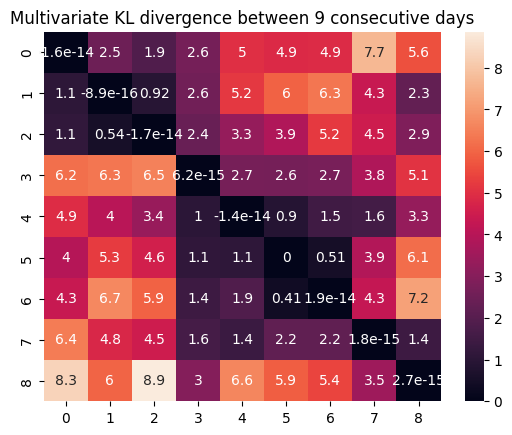

In [ ]:
KL = mv_kl_dfs(mv_days_df)
plot_kl(KL, title="Multivariate KL divergence between 9 consecutive days")